# Sophisticated Inference Demo

## The grid problem

An agent is trying to navigate to a 'goal-state' (red-dot) as optimaly as possible from a given 'start-state'. The agent is occupied with a predefined prior-preference-distribution, damped uniformly from the goal state outwards.

<div>
<img src="1.png" width="500"/>
</div>

Left: Grid task, Right: Predefined prior preference

Ref: K. J. Friston et al., 2021.

# Importing primary modules

In [1]:
# This is needed since pymdp as a module is in a different folder than this demo
import os
import time
import sys
from pathlib import Path

path = Path(os.getcwd())
module_path = str(path.parent.parent) + '/'
sys.path.append(module_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Custom pymdp module with SI agent
import pymdp

# Importing custom environment class
from grid_env_si import grid_environment as Env

# Grid environment

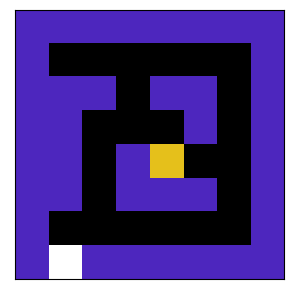

In [4]:
# Initialising the environment 
env = Env(epi_length_limit=8)

# Taking a look at the grid
env.render()

White Square: Agent, Yellow Square: Goal-state, Black: Accesible states, Blue: Inaccesible states

# Generative model for Sophisticated Inference Agent

In [5]:
# Generative model

s1_size = 25
s1_actions = ['N', 'S', 'E', 'W']

o1_size = s1_size

# Hidden states
num_states = [s1_size]
num_factors = len(num_states)

# Controls
num_controls = [len(s1_actions)]

# Observations
num_obs = [o1_size]
num_modalities = len(num_obs)

## Priors of POMDP

### Likelihood matrix

In [6]:
# Inititalising a random A Matrix (Liklihood matrix)
A = pymdp.utils.random_A_matrix(num_obs, num_states)
print("Dimentionality of A:", A.shape)
print("Shape of A[0]:", A[0].shape)

Dimentionality of A: (1,)
Shape of A[0]: (25, 25)


In [7]:
# A is an identity matrix since it is a fully observable environment
A[0] = np.eye(s1_size)

### Transition matrix

In [8]:
# B Matrix
B = pymdp.utils.random_B_matrix(num_states, num_controls)
B[0] = env.get_trueB()

### Prior preference (Predefined in K. J. Friston et al., 2021)

Predefined prior preference:

<div>
<img src="2.png" width="250"/>
</div>

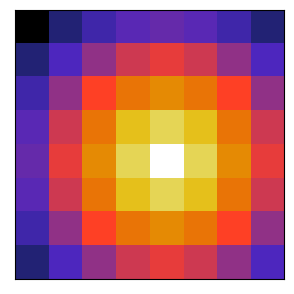

In [9]:
# Building the prior_preference in grid

c = np.zeros((8,8))
X = 4
Y = 4
for i in range(64):
    [x,y] = env.allstatestoc(i)
    c[x][y] = -1*np.sqrt((x - X)**2 + (y - Y)**2)
    
# Taking a look at the structure of prior preference over the grid
env.render_c_matrix(c = c)

In [10]:
# Saving the C matrix to object array in pymdp format for using
C = pymdp.utils.obj_array_zeros(num_obs)

for i in range(env.numS):
    [x,y] = env.statestoc(i)
    C[0][i] = c[x][y]

## Initializing the sophistiacated inference agent from agent_si.py

In [11]:
# Importing SI agent

from pymdp.agent_si import si_agent

In [12]:
# Uncomment to see the documentation for SI agent class
# help(pymdp.agent_si.si_agent)

# Results from K. J. Friston et al.,2021.

<div>
<img src="3.png" width="750"/>
</div>

## Planning horizon of 1

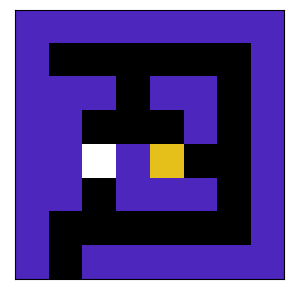

N: 1 Time elapsed: 0.032097816467285156


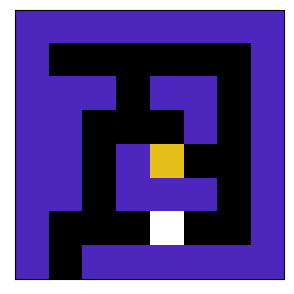

N: 3 Time elapsed: 0.0859370231628418


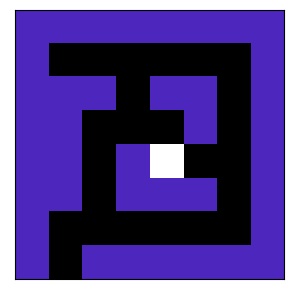

N: 4 Time elapsed: 0.2262883186340332


In [13]:
for planning_depth in [1,3,4]:

    N = planning_depth

    start_time = time.time()

    # Inititalising the agent
    agent = si_agent(num_states=num_states, 
                     num_obs=num_obs, 
                     num_controls=num_controls, 
                     A = A,
                     B = B,
                     C = C[0],
                     planning_horizon = N,
                     planning_precision = 1, 
                     action_precision = 1024,
                     search_threshold = 1/16)

    # planning with tree search to set-up E.F.E i.e. G[numA, numS]
    # agent.plan_tree_search()

    # length of episode
    episode_length = 8

    # Resetting the grid-environment for trial
    obs, info = env.reset(seed=42)

    # trial
    done = False
    tau = 0
    while(done==False):
        #env.render(animation_save = True, N = planning_depth, tau = tau)

        # agent-step
        action = agent.step([obs])
        # print(agent.qs[0].argmax())

        # Env-step
        obs, reward, terminated, truncated, info = env.step(action)
        tau += 1
        # Checking for succesful episode
        if terminated or truncated:
            done = True

    # Talking a look at the environment
    # env.render(animation_save = True, N = planning_depth, tau = tau)
    env.render()

    print("N:",planning_depth, "Time elapsed:", time.time() - start_time)

## Behaviour of agent for planning depth N = 1, 3, and 4

<div>
<img src="animation_N_1.gif" width="250"/>
<img src="animation_N_2.gif" width="250"/>
<img src="animation_N_3.gif" width="250"/>
</div>

# Effect of search threshold in planning

In [14]:
for planning_depth in [1,3,4]:
    
    print("N: ", planning_depth)
    N = planning_depth

    start_time = time.time()

    # Inititalising the agent
    agent = si_agent(num_states=num_states, 
                     num_obs=num_obs, 
                     num_controls=num_controls, 
                     A = A,
                     B = B,
                     C = C[0],
                     planning_horizon = N,
                     planning_precision = 1, 
                     action_precision = 1024,
                     search_threshold = 0)

    # planning with tree search to measure the computational time
    agent.plan_tree_search()
    
    print("N:",planning_depth, "Time elapsed:", time.time() - start_time)

N:  1
N: 1 Time elapsed: 0.0016124248504638672
N:  3
N: 3 Time elapsed: 2.92678165435791
N:  4
N: 4 Time elapsed: 278.39147758483887


When compared to the time elapsed for planning during the demo, we see that setting a search threshold of 1/16, reduced the computational time to 0.23 seconds, from ~276 seconds (N=4 case) when search threshold is zero (i.e. full tree search). 

Also, we can observe that computational time scales exponentially with N when full tree search is implemented. Hence, sophisticated inference becomes computationally intractable without the pruning of tree search using the search_threshold parameter.